In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy.io.wavfile
import scipy
from scipy import signal
import math
import pandas as pd
from datetime import datetime
import timeit

In [51]:
# Helper functions for differentiating/integrating signal
# Approximated by np.diff
def differentiate(wave,frate):
    pwr,freq   = make_spectrum(wave, frate)
    convfilter = np.pi*2*1j*freq  
    pwr        *= convfilter
    dwave = make_wave(pwr)
    return freq,dwave,convfilter

# Approximated by np.cumsum (cdf)
def integrate(wave,frate):
    pwr,freq   = make_spectrum(wave, frate)
    freq[0]    = 1
    convfilter = 1/(np.pi*2*1j*freq)
    pwr        *= convfilter
    pwr[0]      = 0
    freq[0]     = 0
    iwave = make_wave(pwr)
    return freq,iwave,convfilter

# Helper function for generating waves
def genSawToothWave(amp = 1,freq = 1,off = 0,dur = 1,frate = 10000):
    if off < 0:
        print("ERROR: Offset must be greater than 0")
        return
    # Generate SawTooth waveform
    nframes   = int((frate/freq)+1)
    tempwav1  = np.linspace(-amp,amp,nframes)
    tempwav   = tempwav1[:nframes-1]
    # Shift to offset
    startidx = 0
    startidx += int(len(tempwav)*off)
    wavend   = tempwav[:startidx]
    wavstart = tempwav[startidx:]
    wavcycle = np.append(wavstart,wavend)
    # Extend by duration and eliminate consecutive dups
    nwavs,wavfrac = divmod(dur,1/freq)
    wavextended1  = np.tile(wavcycle,int(nwavs))
    wavextended2  = wavcycle[:int(wavfrac*len(wavcycle))]
    wavout = np.append(wavextended1,wavextended2)
    ts2 = np.arange(0,dur,1/frate)
    # Generate Timestamps
    ts         = np.linspace(0,dur,len(wavout))
    #print(2*nframes,len(ts),len(ts2))
    return ts,wavout

def genTriangleWave(amp = 1,freq = 1,off = 0,dur = 1,frate = 10000):
    if off < 0:
        print("ERROR: Offset must be greater than 0")
        return
    # Generate Triangle waveform
    nframes   = int((frate/(2*freq))+1)
    tempwav1  = np.linspace(-amp,amp,nframes)
    tempwav2  = np.linspace(amp,-amp,nframes)
    tempwav   = np.append(tempwav1[:nframes-1],tempwav2[:nframes-1])
    # Shift to offset
    startidx = np.argmax(tempwav >= 0)  
    startidx += int(len(tempwav)*off)
    wavend   = tempwav[:startidx]
    wavstart = tempwav[startidx:]
    wavcycle = np.append(wavstart,wavend)
    # Extend by duration and eliminate consecutive dups
    nwavs,wavfrac = divmod(dur,1/freq)
    wavextended1  = np.tile(wavcycle,int(nwavs))
    wavextended2  = wavcycle[:int(wavfrac*len(wavcycle))]
    wavout = np.append(wavextended1,wavextended2)
    ts2 = np.arange(0,dur,1/frate)
    # Generate Timestamps
    ts         = np.linspace(0,dur,len(wavout))
    return ts,wavout

# Helper Function for converting waves to fft power spectrums back and forth
def make_spectrum(datain, ratein):
    n = len(datain)
    # power spectral density
    hsout = np.fft.rfft(datain)
    # frequency spectrum
    freq = np.fft.rfftfreq(n, d=1./ratein)
    return hsout, freq

def make_wave(hsin):
    wave = np.fft.irfft(hsin)
    return wave

Time/Frequency analysis of FB prices


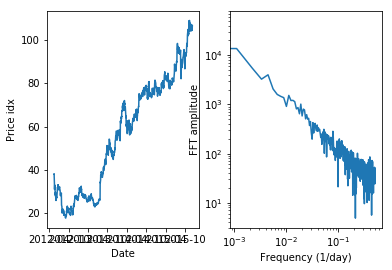

*****REMEMBER: Noise power~frequency relationship P = k-[Beta]log(f)*****
The slope (or Beta Value) =  -1.85798043349
This is close to Brown noise (-2)


In [3]:
# Analyzing Time/Frequency domain of FB prices and diff(FB prices)
print('Time/Frequency analysis of FB prices')
datafolder = '/Users/maxmaguire/Desktop/PostGradWork/DataFolder/CSVFiles/'
fname = datafolder + 'fb.csv'
names = ['date', 'open', 'high', 'low', 'close', 'volume']
df = pd.read_csv(fname, header=0, names=names, parse_dates=[0])
df.head()
#      Time domain
prices = df.close.values[::-1]
dates  = pd.to_datetime(df.date.values[::-1])
#      Frequency domain
spec,fq = make_spectrum(prices, 1)
# Visualize time and frequency domain
dprices = np.diff(prices)
plt.subplot(121)
plt.plot(dates,prices)
plt.ylabel('Price idx')
plt.xlabel('Date')
plt.subplot(122)
plt.plot(fq,np.abs(spec))
plt.ylabel('FFT amplitude')
plt.xlabel('Frequency (1/day)')
plt.xscale('log')
plt.yscale('log')
plt.show()
# Analyze 
x = np.log(fq[1:])
y = np.log(np.power(np.abs(spec[1:]),2))
t = scipy.stats.linregress(x,y)
print('*****REMEMBER: Noise power~frequency relationship P = k-[Beta]log(f)*****' )
print("The slope (or Beta Value) = ", t.slope)
print("This is close to Brown noise (-2)")

Time/Frequency analysis of diff(FB prices)
One way to think about it, is applying a convolution window [1.0 -1.0]


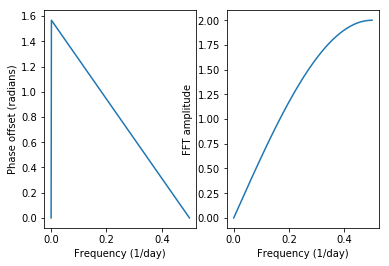

Now to visualize convolution window applied to FB price idx


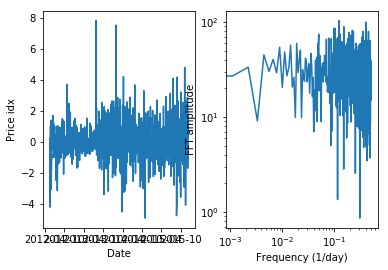

*****REMEMBER: Noise power~frequency relationship P = k-[Beta]log(f)*****
The slope (or Beta Value) =  -0.0572721329414
This is close to Brown noise (-2)


In [32]:
print('Time/Frequency analysis of diff(FB prices)')
print('One way to think about it, is applying a convolution window [1.0 -1.0]')
N = len(prices)
diff_cwindow  = np.array([1, -1])
pdiff_cwindow = np.pad(diff_cwindow,(0,N-2),'constant')
cspec,cfq     = make_spectrum(pdiff_cwindow, 1)
# Visualize time/freq domain of convolution window
plt.subplot(121)
plt.plot(cfq,np.angle(cspec))
plt.ylabel('Phase offset (radians)')
plt.xlabel('Frequency (1/day)')
plt.subplot(122)
plt.plot(cfq,np.abs(cspec))
plt.ylabel('FFT amplitude')
plt.xlabel('Frequency (1/day)')
#plt.xscale('log')
#plt.yscale('log')
plt.show()
#      Time domain
dprices = np.diff(prices)
ddates  = dates[1:]
#      Frequency domain
dspec,dfq = make_spectrum(dprices, 1)
# Visualize time and frequency domain
print("Now to visualize convolution window applied to FB price idx")
plt.subplot(121)
plt.plot(ddates,dprices)
plt.ylabel('Price idx')
plt.xlabel('Date')
plt.subplot(122)
plt.plot(dfq,np.abs(dspec))
plt.ylabel('FFT amplitude')
plt.xlabel('Frequency (1/day)')
plt.xscale('log')
plt.yscale('log')
plt.show()
# Analyze 
x = np.log(dfq[1:])
y = np.log(np.power(np.abs(dspec[1:]),2))
t = scipy.stats.linregress(x,y)
print('*****REMEMBER: Noise power~frequency relationship P = k-[Beta]log(f)*****' )
print("The slope (or Beta Value) = ", t.slope)
print("This is close to Brown noise (-2)")

Notice how the np.diff function differs from differentiating dEf


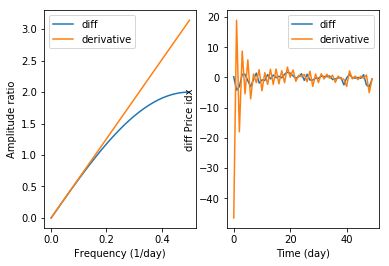

Intuition:  Ef(t) = exp(2pifj t) --> dEf (t) = 2pifj * exp(2pift j)


In [33]:
## Differentiation:
# To differentiate the signal apply differentiation filter to power spectrum and convert to wave
## Intuition:  Ef(t) = exp(2pifj t) --> dEf (t) = 2pifj * exp(2pift j)
fq,diffprices,cfilter = differentiate(prices,1)
print('Notice how the np.diff function differs from differentiating dEf')
plt.subplot(121)
plt.plot(fq,np.abs(cspec))
plt.plot(fq,np.absolute(cfilter))
plt.legend(['diff','derivative'])
plt.xlabel('Frequency (1/day)')
plt.ylabel('Amplitude ratio')
plt.subplot(122)
plt.plot(dprices[0:50])
plt.plot(diffprices[0:50])
plt.xlabel('Time (day)')
plt.ylabel('diff Price idx')
plt.legend(['diff','derivative'])
plt.show()
print('Intuition:  Ef(t) = exp(2pifj t) --> dEf (t) = 2pifj * exp(2pift j)')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


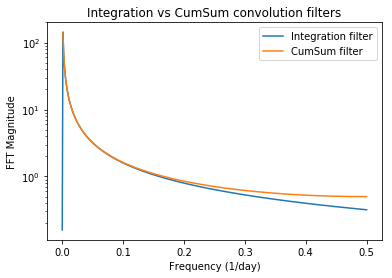

See how integrating/differention compares with cumsum/diff
For a non-periodic signal


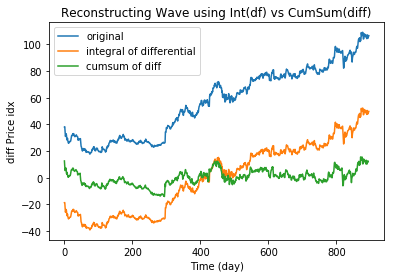

Although the bias is unaccounted for, The reconstructed signal is identical to the original
Intuition:  dEf (t) =  exp(2pift j) --> Ef(t) = (1 / 2pifj ) * exp(2pifj t)


In [50]:
## Integration:
# To integrate the signal divide differentiation filter to power spectrum and convert to wave
## Intuition:  dEf (t) =  exp(2pift j) --> Ef(t) = (1 / 2pifj ) * exp(2pifj t)
fq,iprices,ifilter = integrate(diffprices,1)
# produce cumsum filter 
N = len(prices)
diff_cwindow   = np.array([1, -1])
pdiff_cwindow  = np.pad(diff_cwindow,(0,N-2),'constant')
cssspec,cfq    = make_spectrum(pdiff_cwindow, 1)
cssspec[0]     = 0
cssspec        = 1/cssspec
# ...and recreate wave by applying cumsum filter to spectrum of diff
dprices = np.diff(prices)
ddates  = dates[1:]
dspec,dfq = make_spectrum(dprices, 1)
recspec = dspec * cssspec[1:]
recwave = make_wave(recspec)
# Visualizing cumsum filter vs integration filter
plt.plot(fq,np.absolute(ifilter))
plt.plot(fq,np.absolute(cssspec))
plt.title('Integration vs CumSum convolution filters')
plt.legend(['Integration filter','CumSum filter'])
plt.xlabel('Frequency (1/day)')
plt.ylabel('FFT Magnitude')
plt.yscale('log')
plt.show()
print('See how integrating/differention compares with cumsum/diff')
print('For a non-periodic signal')
plt.title('Reconstructing Wave using Int(df) vs CumSum(diff)')
plt.plot(prices[0:])
plt.plot(iprices[0:])
plt.plot(recwave[0:])
plt.xlabel('Time (day)')
plt.ylabel('diff Price idx')
plt.legend(['original','integral of differential','cumsum of diff'])
plt.show()
print('Although the bias is unaccounted for, The reconstructed signal is identical to the original')
print('Intuition:  dEf (t) =  exp(2pift j) --> Ef(t) = (1 / 2pifj ) * exp(2pifj t)')

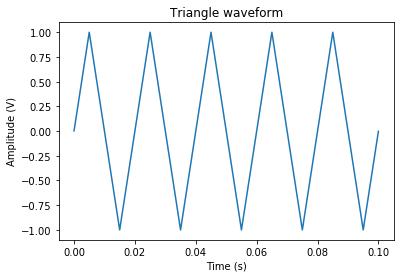

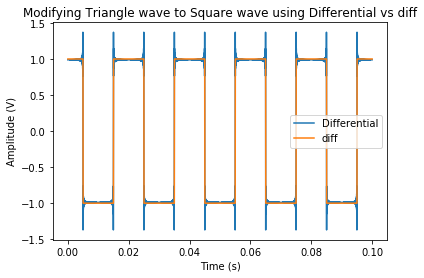

Notice the effects of ringing using Differential vs diff
	-->This can be attributed to the discontinuity of the triange wave


In [74]:
# RINGING
ts,trwave = genTriangleWave(amp = 1,freq = 50,off = 0,dur = 0.1,frate = 44100)
plt.plot(ts,trwave)
plt.title('Triangle waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()
# Compare diff vs differential of Triangle wave
diff_trwave    = np.diff(trwave)
_,d_trwave,_   = differentiate(trwave,44100)
diff_trwave    /= np.amax(diff_trwave)
d_trwave       /= np.amax(d_trwave)-75
plt.plot(ts,d_trwave)
plt.plot(ts[1:],diff_trwave)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.title('Modifying Triangle wave to Square wave using Differential vs diff')
plt.legend(['Differential','diff'])
plt.show()
print('Notice the effects of ringing using Differential vs diff')
print('\t-->This can be attributed to the discontinuity of the triange wave')

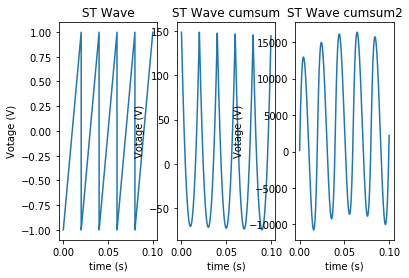

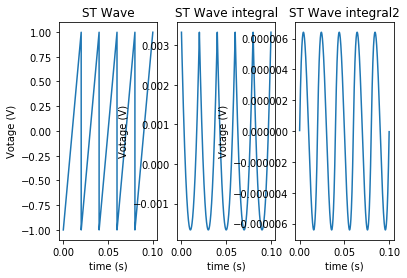

In [101]:
## 2nd Derivative//2nd Integration
# Example:
ts,stwave = genSawToothWave(amp = 1,freq = 50,off = 0,dur = 0.1,frate = 44100)
hs,freq   = make_spectrum(stwave,44100)


# cumsum  1 & 2
cs_stwave       = np.cumsum(stwave) + 150 # unbias
cs2_stwave      = np.cumsum(cs_stwave)
    # diff  1 & 2
diff1_stwave    = np.diff(cs2_stwave)
diff2_stwave    = np.diff(diff1_stwave)
# Integration 1 & 2
_,i_stwave,_  = integrate(stwave,44100)
_,i2_stwave,_ = integrate(i_stwave,44100)
    # Differential 1 & 2
_,d1_stwave,_ = differentiate(i2_stwave,44100)
_,d2_stwave,_ = differentiate(d1_stwave,44100)

# cumsum 1 & 2
plt.subplot(131)
plt.title("ST Wave")
plt.plot(ts,stwave)
plt.ylabel('Votage (V)')
plt.xlabel('time (s)')
plt.subplot(132)
plt.title("ST Wave cumsum")
plt.plot(ts,cs_stwave)
plt.ylabel('Votage (V)')
plt.xlabel('time (s)')
plt.subplot(133)
plt.title("ST Wave cumsum2")
plt.plot(ts,cs2_stwave)
plt.ylabel('Votage (V)')
plt.xlabel('time (s)')
plt.show()
# Integration 1 & 2
plt.subplot(131)
plt.title("ST Wave")
plt.plot(ts,stwave)
plt.ylabel('Votage (V)')
plt.xlabel('time (s)')
plt.subplot(132)
plt.title("ST Wave integral")
plt.plot(ts,i_stwave)
plt.ylabel('Votage (V)')
plt.xlabel('time (s)')
plt.subplot(133)
plt.title("ST Wave integral2")
plt.plot(ts,i2_stwave)
plt.ylabel('Votage (V)')
plt.xlabel('time (s)')
plt.show()